In [1]:
import torch
from torch.distributions import StudentT,Normal,Laplace,Gamma, Bernoulli, Categorical, Uniform
import matplotlib.pyplot as plt
from random import sample,seed
import seaborn as sns
from ssvkernel import ssvkernel

In [2]:
from causal_cocycle.model import cocycle_model,flow_model
from causal_cocycle.optimise import *
from causal_cocycle.loss_functions import Loss
from causal_cocycle.conditioners import Constant_Conditioner, Lin_Conditioner,NN_RELU_Conditioner
from causal_cocycle.transformers import Transformer,Shift_layer,Scale_layer,RQS_layer
from causal_cocycle.helper_functions import likelihood_loss,mmd
from causal_cocycle.kernels import *
from causal_cocycle.regression_functionals import *
from causal_cocycle.distribution_estimation import *

In [3]:
# Helper functions

class Rademacher:

    def sample(self, shape):
        Y = Bernoulli(0.5).sample(shape)
        return Y*2 -1
class BetaPrime:
    def __init__(self, a, b):
        self.a = torch.tensor(a, requires_grad=True)
        self.b = torch.tensor(b, requires_grad=True)
    
    def sample(self, shape):
        # Sample Y ~ Beta(a, b)
        Y = Beta(self.a, self.b).sample(shape)
        # Transform Y to X via X = Y / (1 - Y), which is Beta-Prime distributed.
        return Y / (1 - Y)
    
    def logprob(self, x):
        # log p(x) = lgamma(a+b) - lgamma(a) - lgamma(b) + (a-1)*log(x) - (a+b)*log(1+x)
        return (torch.lgamma(self.a + self.b) -
                torch.lgamma(self.a) -
                torch.lgamma(self.b) +
                (self.a - 1) * torch.log(x) -
                (self.a + self.b) * torch.log(1 + x))
        
class MixtureDist:

    def __init__(self,sd):
        self.sd = torch.tensor(sd,requires_grad = True)

    def sample(self, shape):
        #B = Bernoulli(0.5).sample(shape)
        n,d = shape
        B = torch.cat(
            (torch.zeros(int(n / 2), d, dtype=torch.float),
            torch.ones(int(n /2) , d, dtype=torch.float))
        )
        N = self.sd*Uniform(0.0,0.1).sample(shape)
        C = self.sd*Uniform(0.9,1.00).sample(shape)
        return B*N + (1-B)*C

class MixtureDist3:

    def __init__(self,sd):
        self.sd = torch.tensor(sd,requires_grad = True)

    def sample(self, shape):
        B = Categorical(probs = torch.tensor([1/3,1/3,1/3])).sample(shape)
        N = self.sd*Normal(0,1).sample(shape).abs()
        C = self.sd*Normal(0,1).sample(shape).abs()  
        U = self.sd*Uniform(-0.001,0.001).sample(shape)
        return (B==0)*(C+1) + (B==1)*(-(C+1)) + (B==2)*0
            
class MixtureDist4:

    def __init__(self,sd):
        self.sd = torch.tensor(sd,requires_grad = True)

    def sample(self, shape):
        B = Categorical(probs = torch.tensor([1/4,1/4,1/4,1/4])).sample(shape)
        N = self.sd*Normal(0,1).sample(shape).abs()
        C = self.sd*Normal(0,1).sample(shape).abs()  
        return ((B==0) + (B==1))*(N+1) + (B==2)*(-(C+1)) + (B==3)*0

class likelihood_loss:
    
    def __init__(self,dist):
        self.dist = dist
        if hasattr(dist,'df'):
            self.parameters = self.dist.df.requires_grad_(True)
        else:
            self.parameters = torch.tensor(1.0)
        self.loss_fn = "MLE"
    
    def __call__(self,model,inputs,outputs):
        U,logdet = model.inverse_transformation(inputs,outputs)
        
        return torch.mean(-self.dist.log_prob(U) - logdet) 

def optimise_dynamic(model,
             loss,
             inputs,
             outputs, 
             loss_val = [],
             inputs_val = [],
             outputs_val = [],
             learn_rate = [1e-3], 
             maxiter = 10000,
             miniter = 10000, 
             weight_decay = 0,
            # optimise_loss_params = True, 
             val_loss = True, 
             val_loss_freq = 100,
             val_tol = 1e-3, 
             batch_size = 1024, 
             val_batch_size = 1024,
             batch_sampling = "random", 
             scheduler = False, 
             schedule_milestone = 100, 
             n_schedule = 100,
             lr_mult = 0.90, 
             plot = False, 
             plot_start = 30, 
             print_ = False, 
             optimise_conditioners = True, 
             likelihood_param_opt = False,
             likelihood_param_lr = 0.01):

    # Dimensions
    m = len(outputs)
    m_val = len(outputs_val)

    # Parameters set up
    conditioner_params_list = []
    if len(learn_rate)==1:
        learn_rate = learn_rate*len(model.conditioner)
    for k in range(len(model.conditioner)):
            if optimise_conditioners or (len(optimise_conditioners)>1 and optimise_conditioners[k]==True):
                    conditioner_params_list +=  [{'params' : model.conditioner[k].parameters(),
                                                                        'lr' : learn_rate[k]}]  
    if likelihood_param_opt:
         conditioner_params_list +=  [{'params' : [loss.parameters],
                                        'lr' : likelihood_param_lr}]  
    # Optimiser set up
    optimizer = torch.optim.Adam(conditioner_params_list,weight_decay = weight_decay)  
    if scheduler:
        lr_schedule = torch.optim.lr_scheduler.StepLR(optimizer, 
                                                      step_size = schedule_milestone, 
                                                      gamma=lr_mult)
    batch_start,batch_end = 0,batch_size

    # Optimisation iterations
    Losses = torch.zeros(maxiter)
    Losses_val = torch.zeros(maxiter)
    i = 0 # iter counter
    
    while i < maxiter:
        optimizer.zero_grad()

        #Subsampling
        if batch_size < m and batch_sampling == "random":
            inputs_batch,outputs_batch = get_subsample(inputs,
                                                       outputs,
                                                       batch_size)
        elif batch_size < m:
            if batch_end < m:
                batch_start += batch_size
                batch_end += batch_size
            else:
                batch_start,batch_end = 0,batch_size
            if batch_end > m:
                batch_end = m
            inputs_batch = inputs[batch_start:batch_end]
            outputs_batch = outputs[batch_start:batch_end]
        else:
            inputs_batch,outputs_batch = inputs,outputs

        # Training loss computation
        try:
            Loss = loss(model,inputs_batch,outputs_batch)
        except:
            print("Forward pass error: exiting training iterations")
            break    
        Losses[i] = Loss.detach()

        # Optimisation step
        Loss.backward()
        optimizer.step()
        if scheduler:
            lr_schedule.step()

        # Display
        if print_ or plot:
            if not i % 10:
                clear_output(wait=True)
                if print_:
                    print("Training loss last 10 avg is :",Losses[i-10:i].mean())
                    print(100*i/maxiter," % completion")
                if plot and i > plot_start:
                    ytest = torch.linspace(-2,2,1000)[:,None]
                    plt.figure(figsize=(5, 4))
                    plt.plot(ytest,model.inverse_transformation(ytest,ytest)[0].detach())
                    plt.scatter(outputs,model.inverse_transformation(inputs,outputs)[0].detach())
                    plt.tight_layout()
                    display(plt.gcf())
        i += 1

    # Validation loss computation
    objs = []
    if val_loss and inputs_val != []:
        if loss_val == []:
            loss_val = loss
        with torch.no_grad():
            objs.append(loss_val(model,inputs_val[:val_batch_size],outputs_val[:val_batch_size]))
        
    return objs

In [4]:
# Experimental settings
n = 1000 # training samples
d = 1 # input dims
trials = 1 # experiment replications
ngrid = 100 # grid points for CATE
zlist = torch.linspace(-2,2,ngrid)[:,None]/d**0.5 # grid generation for CATE
a = torch.tensor([1.0]) # Int level
nu = 1 # DoF
sd = 1.0 # \sigma^2 on Y|X,Z
mc_samples = 10**5 # MC samples to approx expectations
hyper_ls = 2**torch.linspace(-2,2,5)
rng = 10#1

# Interventions
intervention_hard = lambda a,x : a + x*0
intervention_shift = lambda a,x : a + x
intervention_scale = lambda a,x : a*x
interventions = [intervention_shift]

In [5]:
# Training set up
train_val_split = 1
ntrain = int(n)
learn_rate = [1e-3]
scheduler = False
val_tol = 1e-3
batch_size = 128
val_loss = False
maxiter = 5000
miniter = 5000
RQS_bins = 8
df_init = 10.0

# Model names
Models = ["True", "Parametric", "G-RQS SCM","L-RQS SCM"]

# Models
SCM_models = []

tail_adapt = [False,False,False,False, True]


grad = False

In [6]:
# Estimated CATEs
CATEs_param_est = torch.zeros(len(Models),len(interventions),trials,ngrid)
for t in range(trials):
    
    # Seed set
    seed(t+rng)
    torch.manual_seed(t+rng)
    
    # Getting sample data
    #U = MixtureDist(1.0).sample((n,1)).detach()
    U = MixtureDist(1.0).sample((n,1)).detach()
    #U = MixtureDist4(1.0).sample((n,1)).detach()
    #U = Bernoulli(0.5).sample((n,1)).detach()
    #U = Rademacher().sample((n,1)).detach()
    ## base distributions
    SCM_base_distributions = [
        #Bernoulli(0.5),
        #Bernoulli(U.mean()),
        #Rademacher(),
        #Rademacher(),
        MixtureDist(1.0),
        MixtureDist(1.0),
        #MixtureDist3(((U[U!=0].abs()-1)**2).mean()), # Parametric MLE
        #MixtureDist4(1.0),
        Normal(0,1),
        Laplace(0,1),
    ]
        
    # Transformers and conditioners
    SCM_conditioners = [
        [Constant_Conditioner(init = torch.log(torch.exp(torch.ones(1))-1), grad = grad, full = False)],
        [Constant_Conditioner(init = torch.log(torch.exp(torch.ones(1))-1), grad = grad, full = False)],
        [Constant_Conditioner(init = torch.ones(1), full = False),
          Constant_Conditioner(init = torch.ones(1), full = False),
          Constant_Conditioner(init = torch.ones((1,3*RQS_bins+2))*1.0),
          Constant_Conditioner(init = torch.ones(1), full = False),
          Constant_Conditioner(init = torch.ones(1), full = False)],
        [Constant_Conditioner(init = torch.ones(1), full = False),
          Constant_Conditioner(init = torch.ones(1), full = False),
          Constant_Conditioner(init = torch.ones((1,3*RQS_bins+2))*1.0),
          Constant_Conditioner(init = torch.ones(1), full = False),
          Constant_Conditioner(init = torch.ones(1), full = False)],
    ]
    SCM_transformers = [
        Transformer([Scale_layer()],logdet = True),
        Transformer([Scale_layer()],logdet = True),
        Transformer([Shift_layer(),Scale_layer(),RQS_layer(),Shift_layer(),Scale_layer()],logdet = True),
        Transformer([Shift_layer(),Scale_layer(),RQS_layer(),Shift_layer(),Scale_layer()],logdet = True),
    ]
    
    # Model estimation
        
    # Getting input-output pairs
    inputs_train,outputs_train = U,U
    inputs_val,outputs_val = [],[]

    # SCM training
    for m in range(len(Models)):
        loss_fn = likelihood_loss(dist = SCM_base_distributions[m])
        model = flow_model(SCM_conditioners[m],SCM_transformers[m])
        if m > 1:
            model.transformer.logdet = True
            optimise_dynamic(model,
                          loss_fn,
                          inputs_train,
                          outputs_train,
                          inputs_val,
                          outputs_val, 
                          batch_size = batch_size,
                          learn_rate = learn_rate,
                          print_ = True,
                          plot = False, 
                          plot_start = 0,
                          miniter = miniter,
                          maxiter = maxiter, 
                          val_tol = val_tol,
                          val_loss = val_loss,
                          scheduler = scheduler,
                          likelihood_param_opt = True)
        model.transformer.logdet = False
        SCM_models.append(model)

        if tail_adapt[m]:
            SCM_base_distributions[m] = StudentT(SCM_base_distributions[m].df.detach(),0,1)
    
    print(t)

Training loss last 10 avg is : tensor(-1.4739)
99.8  % completion
0


In [7]:
SCM_models[3].transformer.logdet = False

In [8]:
Z = Normal(0,1).sample((mc_samples,1))
Y0pred = []
for m in range(len(Models)):
    basepred = SCM_base_distributions[m].sample((mc_samples,1))
   # Y0pred.append(torch.sigmoid(SCM_models[m].transformation(basepred,basepred).detach()))
    Y0pred.append(torch.sigmoid(SCM_models[m].transformation(basepred,basepred).detach())) #+ Z*0.025)
Y0pred.append(Y0pred[0][:n])

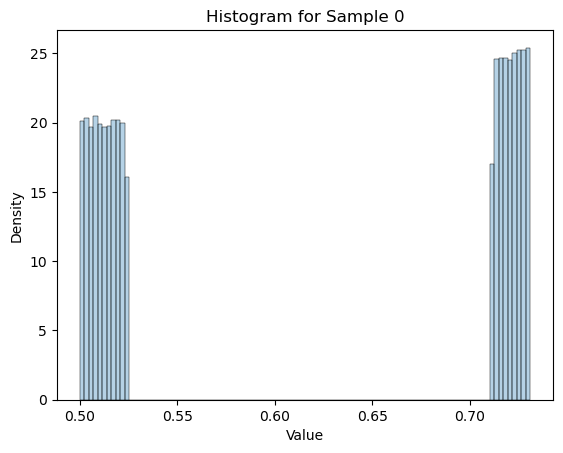

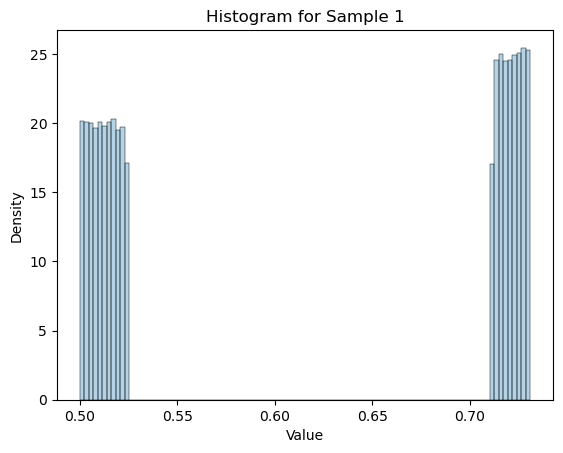

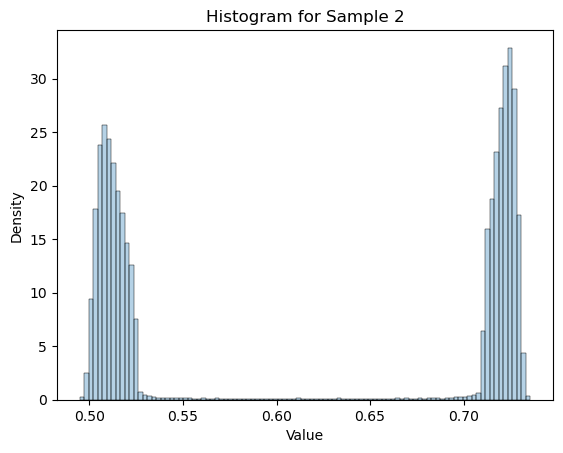

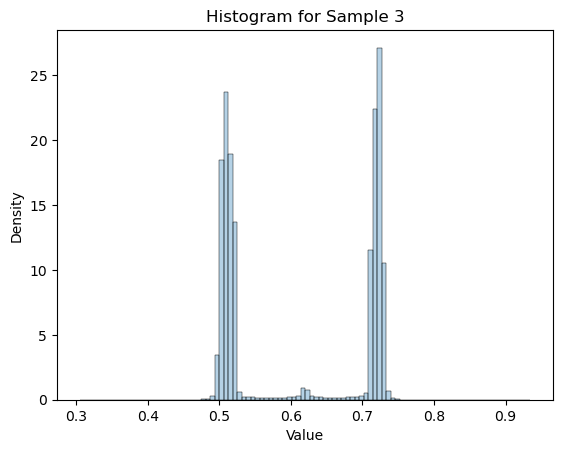

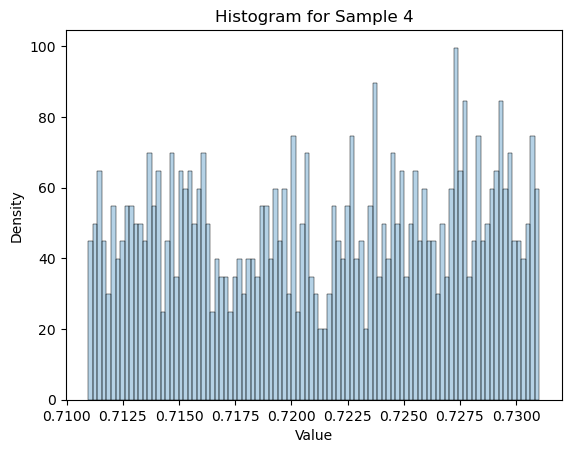

In [9]:
for i in range(5):
    data = Y0pred[i][:, 0].numpy()
    #x = np.linspace(0,1,1000)
    #y = ssvkernel(data, tin=x, M=80, nbs=100, WinFunc='Gauss')
    #plt.plot(x,y[0])
    #plt.fill_between(x,0*y[0],y[0], alpha = 0.5)    
    sns.histplot(data, bins=100, alpha=0.33, stat = "density")
    plt.xlabel("Value")
    plt.ylabel("Density")
    plt.title(f"Histogram for Sample {i}")
    plt.show()

tensor(-1.5143, grad_fn=<MeanBackward0>) tensor(-1.0179, grad_fn=<MeanBackward0>)
tensor(-1.6918, grad_fn=<MeanBackward0>) tensor(-2.0013, grad_fn=<MeanBackward0>)


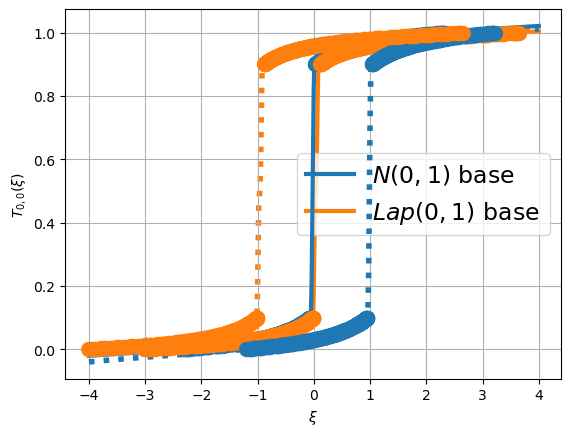

In [10]:
# Checking Gauss likelihood
Utrain = U#torch.tensor([[1.0],[0.0]])
Lik = likelihood_loss(Normal(0,1))
SCM_models[2].transformer.logdet = True

# Changing Gauss map
from copy import deepcopy
i = 0
width_shift = 0.46875
height_shift = 0
G_model = deepcopy(SCM_models[2])
G_model.conditioner[2].params = G_model.conditioner[2].params.detach()
G_model.conditioner[2].params[:,i] += width_shift
G_model.conditioner[2].params[:,i+RQS_bins] += height_shift
print(Lik(SCM_models[2],Utrain,Utrain),Lik(G_model,Utrain,Utrain))
SCM_models[2].transformer.logdet = False
G_model.transformer.logdet = False
print(SCM_base_distributions[3].log_prob(SCM_models[3].inverse_transformation(Utrain,Utrain)).mean(),
      SCM_base_distributions[3].log_prob(SCM_models[3].inverse_transformation(Utrain,Utrain)-1.0).mean())

# Plotting maps + transformed maps
ytest = torch.linspace(-4,4,1000)[:,None]
plt.plot(ytest,SCM_models[2].transformation(ytest,ytest).detach(), lw = 3, label = r"$N(0,1)$ base", color = "C0", alpha = 1.0, zorder = 11)
plt.plot(ytest,G_model.transformation(ytest,ytest).detach(), color = "C0", lw = 4.0, ls = "dotted", zorder = 10)
plt.plot(ytest,SCM_models[3].transformation(ytest,ytest).detach(), lw = 3, label = r"$Lap(0,1)$ base", color = "C1", alpha = 1.0)
plt.plot(ytest,SCM_models[3].transformation(ytest,ytest+1.0).detach(), lw = 4.0, ls = "dotted", color = "C1", zorder = 0)

plt.scatter(SCM_models[2].inverse_transformation(Utrain,Utrain).detach(),Utrain, s = 100, color = "C0", zorder = 100, alpha = 1)
plt.scatter(SCM_models[3].inverse_transformation(Utrain,Utrain).detach(),Utrain, s = 100, color = "C1", zorder = 100, alpha = 1)
plt.scatter(G_model.inverse_transformation(Utrain,Utrain).detach(),Utrain, s = 100, color = "C0", zorder = 100, alpha = 0.75)
plt.scatter(SCM_models[3].inverse_transformation(Utrain,Utrain).detach()-1.0,Utrain, s = 100, color = "C1", zorder = 100, alpha = 0.75)


plt.xlabel(r"$\xi$")
plt.ylabel(r"$T_{0,0}(\xi)$")
plt.legend(fontsize = 17)
plt.grid(zorder = 10)

In [ ]:
SCM_models_copy = deepcopy(SCM_models)
SCM_models_copy[2] = G_model

Z = Normal(0,1).sample((mc_samples,1))
Y0pred = []
for m in range(len(Models)):
    basepred = SCM_base_distributions[m].sample((mc_samples,1))
   # Y0pred.append(torch.sigmoid(SCM_models[m].transformation(basepred,basepred).detach()))
    Y0pred.append(torch.sigmoid(SCM_models_copy[m].transformation(basepred,basepred).detach()) + Z*0.025)
Y0pred.append(Y0pred[0][:n])

for i in range(5):
    data = Y0pred[i][:, 0].numpy()
    #x = np.linspace(0,1,1000)
    #y = ssvkernel(data, tin=x, M=80, nbs=100, WinFunc='Gauss')
    #plt.plot(x,y[0])
    #plt.fill_between(x,0*y[0],y[0], alpha = 0.5)    
    sns.histplot(data, bins=100, alpha=0.33, stat = "density")
    plt.xlabel("Value")
    plt.ylabel("Density")
    plt.title(f"Histogram for Sample {i}")
    plt.show()

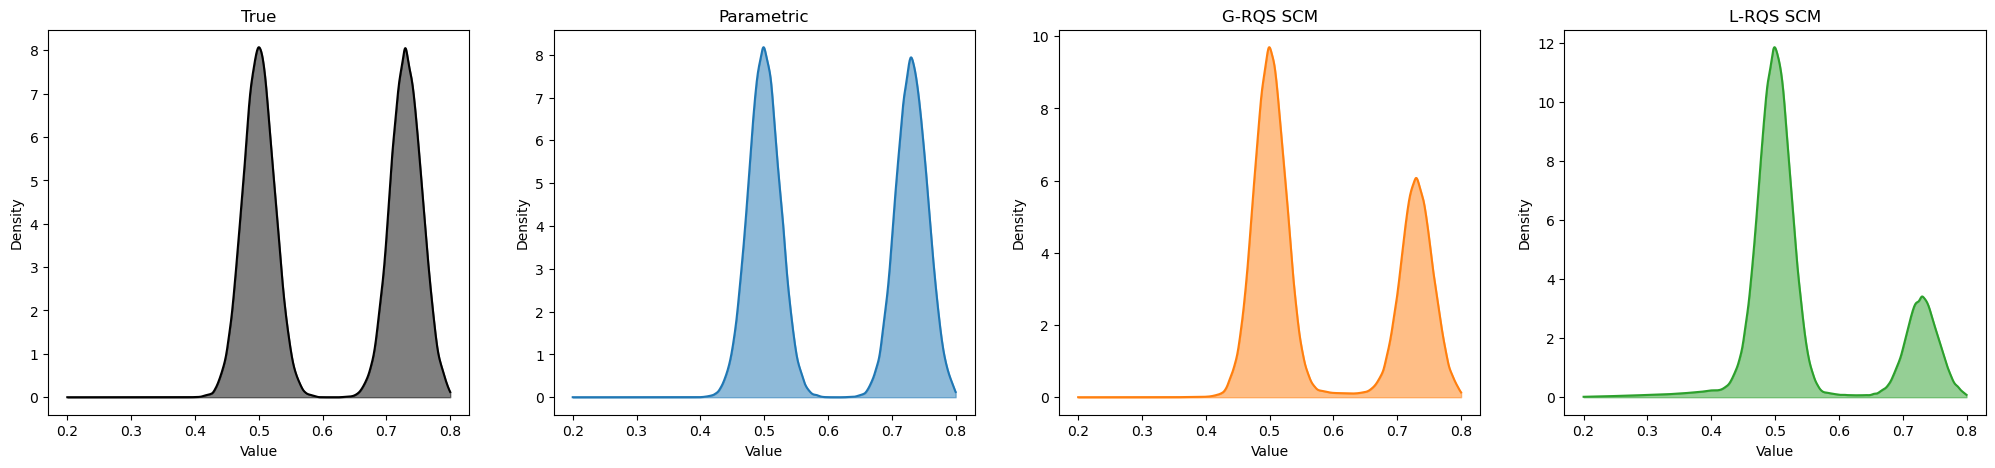

In [21]:

colours = ["black"] + plt.rcParams['axes.prop_cycle'].by_key()['color']
fig,axs = plt.subplots(1,4,figsize = (25,5))
for i in range(len(Models)):
    data = Y0pred[i][:, 0].numpy()
    x = np.linspace(0.2,0.8,1000)
    y = ssvkernel(data, tin=x, M=80, nbs=100, WinFunc='Gauss')
    axs[i].plot(x,y[0], color = colours[i])
    axs[i].fill_between(x,0*y[0],y[0], alpha = 0.5, color = colours[i])    
    #sns.histplot(data, bins=100, alpha=0.33, stat = "density")
    axs[i].set_xlabel("Value")
    axs[i].set_ylabel("Density")
    axs[i].set_title(Models[i])

In [ ]:
t = torch.linspace(-1,1,100)[None]
cdfs = []
for i in range(6):
    cdfs.append((Y0pred[i]<=t).float().mean(0))
    plt.plot(cdfs[i])
plt.show()

for i in range(6):
    print((cdfs[0]-cdfs[i]).abs().mean())

for i in range(6):
    print((cdfs[0]-cdfs[i]).abs().max())

for i in range(6):
    plt.plot((cdfs[0]-cdfs[i]).abs())

In [ ]:
X = Normal(0,1).sample((n,1))
Y,Y0 = torch.sigmoid(X+U), torch.sigmoid(U)
plt.scatter(Y,Y0)

In [ ]:
from ssvkernel import ssvkernel
data = Y0pred[0][:, 0].numpy()
x = np.linspace(0,1,1000)
y0 = ssvkernel(data, tin=x, M=80, nbs=100, WinFunc='Gauss')

In [ ]:
plt.plot(x,y0[0])
plt.fill_between(x,0*y0[0],y0[0], alpha = 0.5)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
colours = ["black"] + plt.rcParams['axes.prop_cycle'].by_key()['color']
fig,axs = plt.subplots(1,4,figsize = (25,5))
for i in range(len(Models)):
    data = Y0pred[i][:, 0].numpy()
    x = np.linspace(0,1,1000)
    y = ssvkernel(data, tin=x, M=80, nbs=100, WinFunc='Gauss')
    axs[i].plot(x,y[0], color = colours[i])
    axs[i].fill_between(x,0*y[0],y[0], alpha = 0.5, color = colours[i])    
    #sns.histplot(data, bins=100, alpha=0.33, stat = "density")
    axs[i].set_xlabel("Value")
    axs[i].set_ylabel("Density")
    axs[i].set_title(Models[i])

In [ ]:
for i in range(5):
    print(((Y0pred[i]>=0.49) * (Y0pred[i]<=0.51)).float().mean())

In [ ]:
for i in range(5):
    print((torch.sigmoid(Upred[i][:,0])<=0.01).float().mean())
print("\n")

for i in range(5):
    print((torch.sigmoid(Upred[i][:,0])>=0.99).float().mean())
print("\n")

for i in range(5):
    print((torch.sigmoid(Upred[i][:,0])==0.5).float().mean())
print("\n")